In [47]:
import pandas as pd
import requests
import folium
from urllib.parse import quote

- 검색 리스트 입력

In [48]:
# locations = '영등포역 신도림역 당산역 여의도역 영등포구청역'.split()
# locations = input().split()
locations = ['혜화역', '종각역', '동대문역', '시청역', '서울역']

- 도로명 주소 검색, 리스트 생성

In [49]:
with open('keys/도로명주소apiKey.txt') as file:
    road_key = file.read()

base_url = 'https://www.juso.go.kr/addrlink/addrLinkApi.do'
road_addr_list = []

for location in locations:
    url = f'{base_url}?confmKey={road_key}&currentPage=1&countPerPage=10&keyword={quote(location)}&resultType=json'
    res = requests.get(url).text
    data = json.loads(res)
    road_addr = data['results']['juso'][0]['roadAddr']
    road_addr_list.append(road_addr)

df_loc = pd.DataFrame({
    '역명': locations, '주소': road_addr_list
})
df_loc

,역명,주소
0,혜화역,서울특별시 종로구 대학로 지하120 (명륜4가)
1,종각역,서울특별시 종로구 종로 지하55 (종로1가)
2,동대문역,서울특별시 종로구 율곡로 지하308 (종로6가)
3,시청역,서울특별시 중구 서소문로 지하127 (서소문동)
4,서울역,서울특별시 용산구 만리재로 202 (서계동)


- 데이터 프레임에 좌표추가

In [50]:
with open('keys/카카오apiKey.txt') as file:
    kakao_key = file.read()
base_url = 'https://dapi.kakao.com/v2/local/search/address.json'
header = {
    'Authorization': f'KakaoAK {kakao_key}'
}

lat_list, lng_list = [], []
for i in df_loc.index:
    url = f'{base_url}?query={quote(df_loc["주소"][i])}'
    result = requests.get(url, headers=header).json()
    lat_list.append(float(result['documents'][0]['y']))
    lng_list.append(float(result['documents'][0]['x']))

df_loc['위도'] = lat_list
df_loc['경도'] = lng_list

df_loc


,역명,주소,위도,경도
0,혜화역,서울특별시 종로구 대학로 지하120 (명륜4가),37.581804,127.001978
1,종각역,서울특별시 종로구 종로 지하55 (종로1가),37.570214,126.983240
2,동대문역,서울특별시 종로구 율곡로 지하308 (종로6가),37.570412,127.009547
3,시청역,서울특별시 중구 서소문로 지하127 (서소문동),37.563579,126.975389
4,서울역,서울특별시 용산구 만리재로 202 (서계동),37.554943,126.968463


- 좌표 지도에 표시


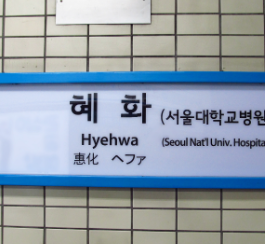
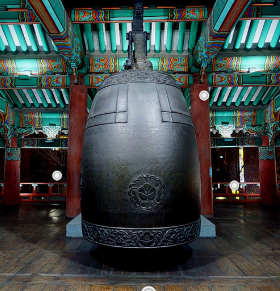
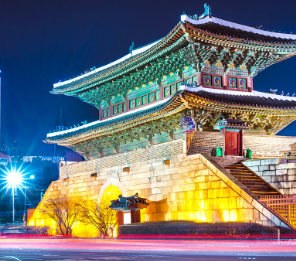
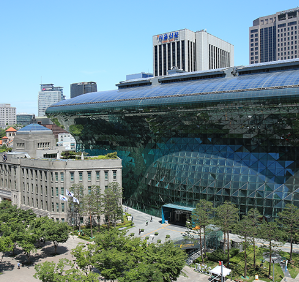
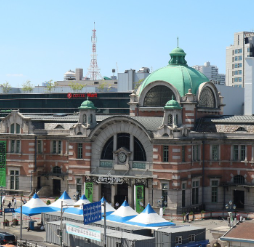

In [51]:
map = folium.Map(location=[df_loc['위도'].mean(), df_loc['경도'].mean()], zoom_start=13)
for i in df_loc.index:
    folium.Marker(
        location=[df_loc['위도'][i].round(6), df_loc['경도'][i].round(6)],
        tooltip=df_loc['역명'][i],
        popup=folium.Popup(df_loc['주소'][i], max_width=300),
        icon=folium.CustomIcon(f'data/{i}.png', icon_size=(50,50))
    ).add_to(map)
title_html = '<h3 align="center" style="font-size:20px"><b>집 주변 5개 역</b></h3>'
map.get_root().html.add_child(folium.Element(title_html))
map